In [1]:
import os
# 打印当前工作目录
print("Current working directory:", os.getcwd())
import sys
print("current python environment:", sys.executable)

import pandas as pd
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import numpy as np

Current working directory: /Users/libowen/SD3rd/RP/code
current python environment: /Users/libowen/miniforge3/envs/windmap/bin/python


In [2]:
# 读取主数据
df = pd.read_parquet("energinet/masterdatawind.parquet")
pd.set_option('display.max_columns', None)
df.head()  # 默认前5行

GSRN Turbine_short_name                    Turbine_name  \
0  000000000000000000          348-80052  Husstandsmølle v/ Morten Mørup   
1  570714700000000027          791-079/1                     Parkstien 1   
2  570714700000000027          791-079/1                     Damhusåen 2   
3  570714700000000034          791-079/2                     Parkstien 1   
4  570714700000000034          791-079/2                     Damhusåen 1   

  Turbine_type         Parent_GSRN                In_service  \
0            H                None 2012-08-11 00:00:00+00:00   
1            M  570714700000050459 1993-02-03 00:00:00+00:00   
2            M  570714700000050459 1993-02-03 00:00:00+00:00   
3            M  570714700000050459 1993-02-03 00:00:00+00:00   
4            M  570714700000050459 1993-02-03 00:00:00+00:00   

                Out_service BBR_municipal Placement       UTM_x        UTM_y  \
0 2014-10-01 00:00:00+00:00           760      None         NaN          NaN   
1                       NaT           101      LAND  720898.353  6171174.877   
2                       NaT           101      LAND  720898.353  6171174.877   
3                       NaT           101      LAND  720993.352  6171226.877   
4                       NaT           101      LAND  720993.352  6171226.877   

   UTM_precision  Capacity_kw     Model Manufacturer  Rotor_diameter  \
0            NaN         11.0  44707813     44707128            13.0   
1            1.0        225.0  44707587     44707106            27.0   
2            1.0        225.0  44707587     44707106            27.0   
3            1.0        225.0  44707587     44707106            27.0   
4            1.0        225.0  44707587     44707106            27.0   

   Navhub_height  Fullload_amount  Fullload_quota Fullload_datetime  \
0           18.2              NaN             NaN               NaT   
1           30.0              NaN         15000.0               NaT   
2           30.0              NaN         15000.0               NaT   
3           30.0              NaN         15000.0               NaT   
4           30.0              NaN         15000.0               NaT   

  Actor_short_name     Actor_name             Valid_to           Valid_from  
0       EGENPROD-W  Egenproducent  2014-10-31 23:59:59  2012-07-31 23:00:00  
1             None           None                 None                 None  
2             None           None                 None                 None  
3             None           None                 None                 None  
4             None           None                 None                 None

In [3]:
# 处理时间字段
df['In_service'] = pd.to_datetime(df['In_service'], errors='coerce')
df['Out_service'] = pd.to_datetime(df['Out_service'], errors='coerce')
df['In_service'] = df['In_service'].dt.tz_localize(None)
df['Out_service'] = df['Out_service'].dt.tz_localize(None)

today = pd.Timestamp(datetime.today().date())

# 判断是否仍在运行
df['status'] = df.apply(lambda row: 'Available' if row['In_service'] <= today and 
                        (pd.isna(row['Out_service']) or row['Out_service'] > today) 
                        else 'Retired', axis=1)

In [4]:
# 创建 GeoDataFrame（EPSG:25832 是 UTM zone 32N）
gdf = gpd.GeoDataFrame(df, 
    geometry=[Point(xy) for xy in zip(df['UTM_x'], df['UTM_y'])],
    crs="EPSG:25832")

# 转换为经纬度（EPSG:4326）
gdf = gdf.to_crs("EPSG:4326")

In [5]:
available = gdf[(gdf['status'] == 'Available')]
retired = gdf[(gdf['status'] == 'Retired')]

print(f"Available turbines: {len(available)}")
print(f"Retired turbines: {len(retired)}")
# 只显示包含 UTM 坐标的前几条记录
retired_valid = retired[retired['UTM_x'].notnull() & retired['UTM_y'].notnull()]
retired_valid[['GSRN', 'Turbine_name', 'UTM_x', 'UTM_y']].head()

Available turbines: 79826
Retired turbines: 5324


GSRN   Turbine_name     UTM_x      UTM_y
11  570714700000000072  Avedøre Holme  717288.0  6167432.0
14  570714700000000089  Avedøre Holme  717423.0  6167422.0
16  570714700000000096  Avedøre Holme  717556.0  6167412.0
17  570714700000000102  Avedøre Holme  717690.0  6167403.0
18  570714700000000102  Avedøre Holme  717690.0  6167403.0

In [6]:
# 总风机数量（每一行一条记录）
total_turbines = len(df)
total_available_turbines = len(available)

# 按 Turbine_type 分类
available_type_counts = available['Turbine_type'].value_counts()

print(f"在役风机总数（已过滤）: {total_available_turbines}\n")
print("按 Turbine_type 分类的数量：")
print(available_type_counts)

在役风机总数（已过滤）: 79826

按 Turbine_type 分类的数量：
Turbine_type
W    54289
H    15495
P     6342
M     3700
Name: count, dtype: int64


## standalone turbine visualization

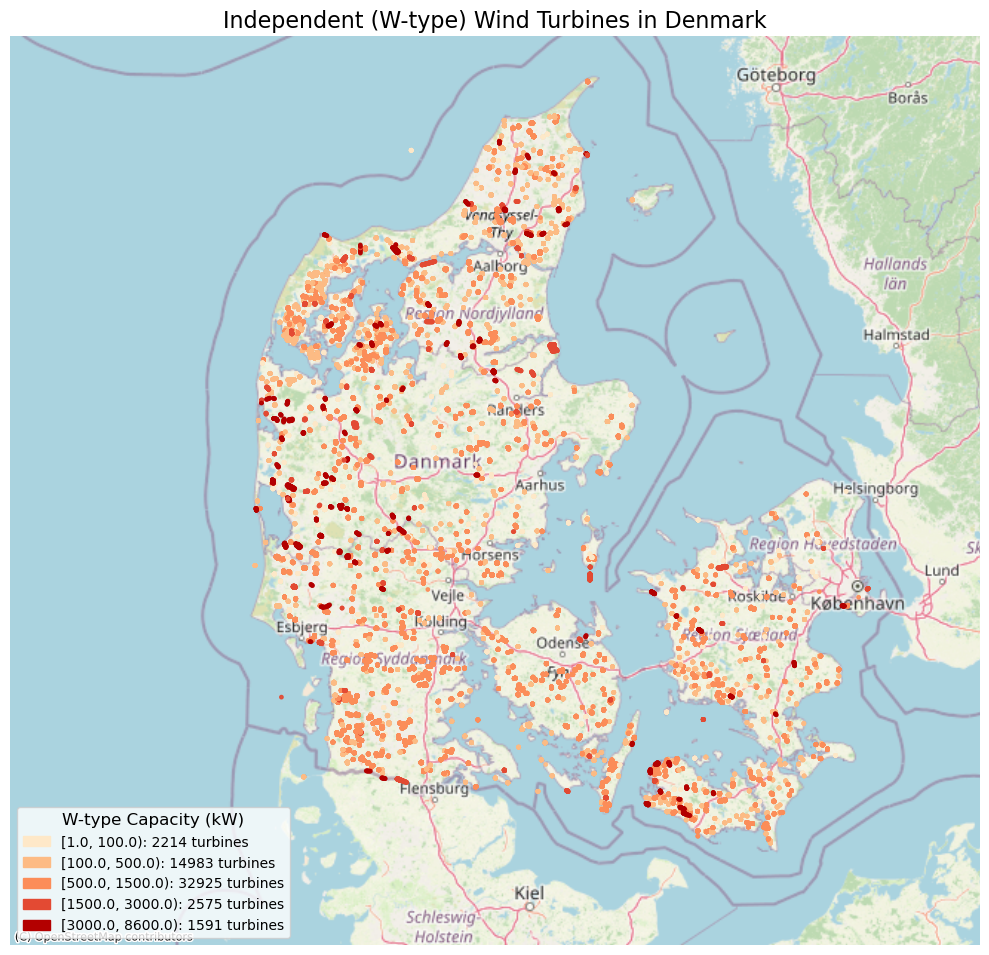

In [17]:
import matplotlib.patches as mpatches

# 计算每个容量区间的风机数量
bin_counts = available_wm['capacity_bin'].value_counts().sort_index()

# 自定义颜色映射（对应 bins 数量 - 1）
colors = [
    '#fee8c8',  # light peach
    '#fdbb84',  # light orange
    '#fc8d59',  # orange
    '#e34a33',  # dark orange-red
    '#b30000',  # dark red
]
cmap = ListedColormap(colors)

# 绘图
fig, ax = plt.subplots(figsize=(10, 12))

available_wm.plot(
    ax=ax,
    column='capacity_bin',
    cmap=cmap,
    markersize=6,
    alpha=0.9
)

# 添加 OpenStreetMap 底图
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 设置地图范围
ax.set_xlim(700000, 1500000)
ax.set_ylim(7200000, 7950000)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 构建图例（手动）
legend_elements = []
for color, (interval, count) in zip(colors, bin_counts.items()):
    label = f"{interval}: {count} turbines"
    patch = mpatches.Patch(color=color, label=label)
    legend_elements.append(patch)

# 添加图例
ax.legend(
    handles=legend_elements,
    loc='lower left',
    title="W-type Capacity (kW)",
    fontsize=10,
    title_fontsize=12
)

# 标题和样式
plt.title("Independent (W-type) Wind Turbines in Denmark", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

## Installation Year Distribution of W-type Wind Turbines in Denmark

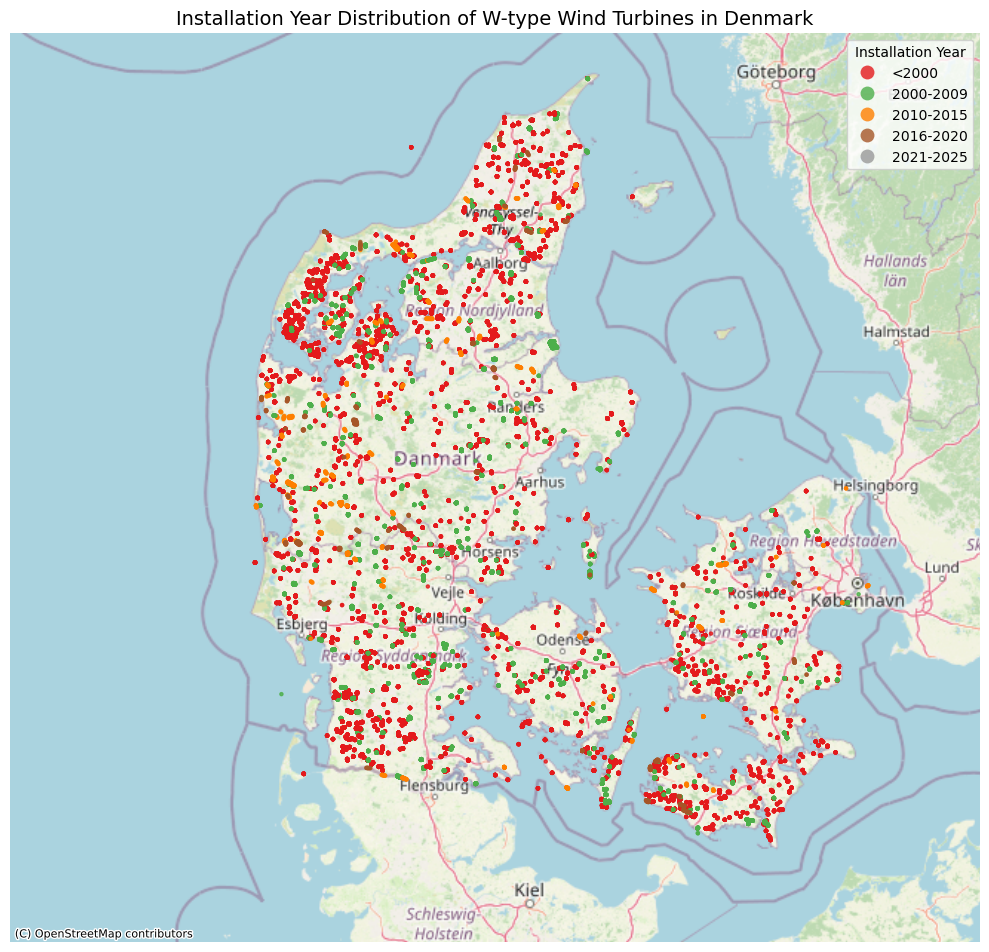

In [13]:
# 只筛选 W 型 + 仍在运行 + 有坐标的风机
available_w = gdf[
    (gdf['Turbine_type'] == 'W') &
    (gdf['status'] == 'Available') &
    (gdf.geometry.notnull()) &
    (gdf['In_service'].notnull())
].copy()

# 提取年份
available_w['install_year'] = available_w['In_service'].dt.year

# 坐标转换
available_w = available_w.to_crs(epsg=3857)

# 分箱（你可以根据年份调整区间）
bins = [0, 1999, 2009, 2015, 2020, 2025]
labels = ['<2000', '2000-2009', '2010-2015', '2016-2020', '2021-2025']
available_w['year_bin'] = pd.cut(available_w['install_year'], bins=bins, labels=labels, right=True)

# 绘图
fig, ax = plt.subplots(figsize=(10, 12))
available_w.plot(
    ax=ax,
    column='year_bin',
    cmap='Set1',
    markersize=5,
    legend=True,
    alpha=0.8,
    legend_kwds={'title': 'Installation Year'}
)

ax.set_xlim(700000, 1500000)
ax.set_ylim(7200000, 7950000)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Installation Year Distribution of W-type Wind Turbines in Denmark", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## Manufacturer Distribution of W-type Wind Turbines in Denmark

Index(['GSRN', 'Turbine_short_name', 'Turbine_name', 'Turbine_type',
       'Parent_GSRN', 'In_service', 'Out_service', 'BBR_municipal',
       'Placement', 'UTM_x', 'UTM_y', 'UTM_precision', 'Capacity_kw', 'Model',
       'Manufacturer', 'Rotor_diameter', 'Navhub_height', 'Fullload_amount',
       'Fullload_quota', 'Fullload_datetime', 'Actor_short_name', 'Actor_name',
       'Valid_to', 'Valid_from', 'status', 'geometry', 'install_year'],
      dtype='object')


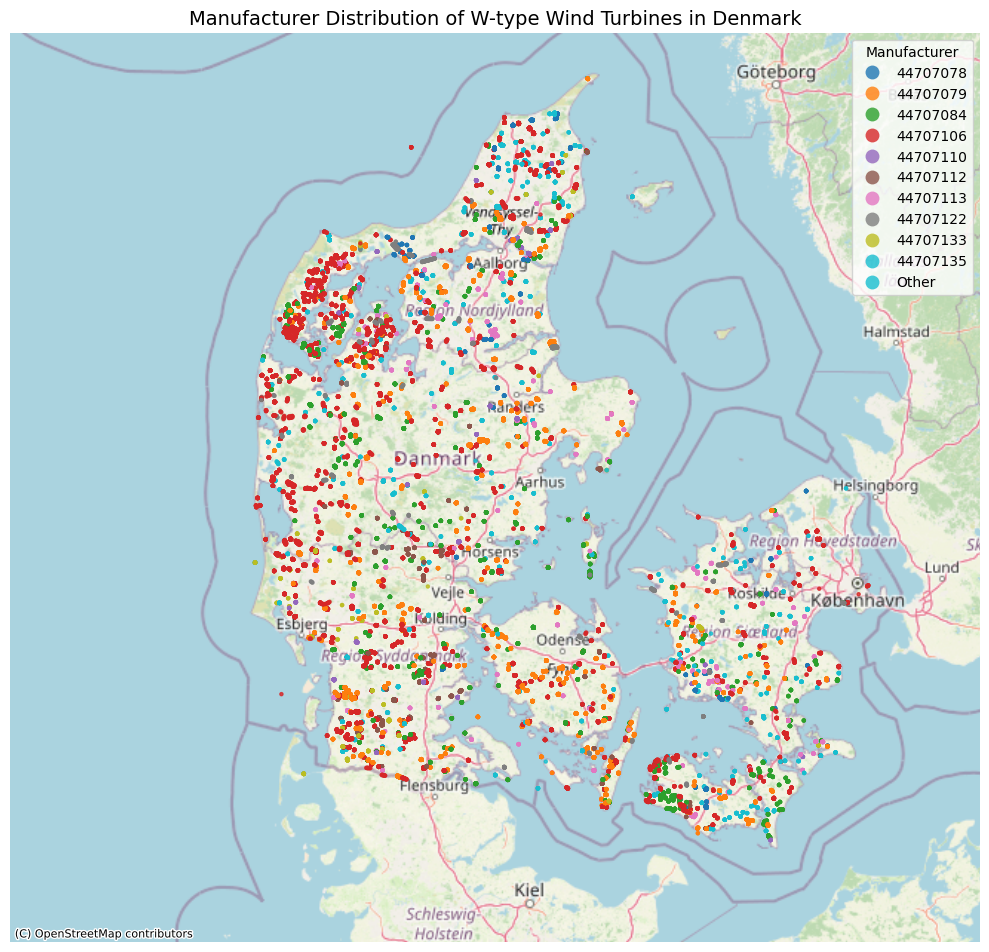

In [14]:
# 确保有厂商字段，字段名可能是 Manufacturer、Producer 或 Turbine_name
print(gdf.columns)  # 查看列名

# 假设你的厂商字段是 'Manufacturer'，如果没有可换成 'Turbine_name'
manufacturer_col = 'Manufacturer'  # 改成你的字段名

available_w_manuf = gdf[
    (gdf['Turbine_type'] == 'W') &
    (gdf['status'] == 'Available') &
    (gdf[manufacturer_col].notnull()) &
    (gdf.geometry.notnull())
].copy()

# 只取前10个最多厂商，其余归为 Other
top_manufacturers = available_w_manuf[manufacturer_col].value_counts().nlargest(10).index
available_w_manuf['manufacturer_label'] = available_w_manuf[manufacturer_col].apply(
    lambda x: x if x in top_manufacturers else 'Other'
)

available_w_manuf = available_w_manuf.to_crs(epsg=3857)

# 绘图
fig, ax = plt.subplots(figsize=(10, 12))
available_w_manuf.plot(
    ax=ax,
    column='manufacturer_label',
    cmap='tab10',
    markersize=5,
    legend=True,
    alpha=0.8,
    legend_kwds={'title': 'Manufacturer'}
)

ax.set_xlim(700000, 1500000)
ax.set_ylim(7200000, 7950000)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Manufacturer Distribution of W-type Wind Turbines in Denmark", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## Rotor Diameter Distribution of W-type Wind Turbines in Denmark

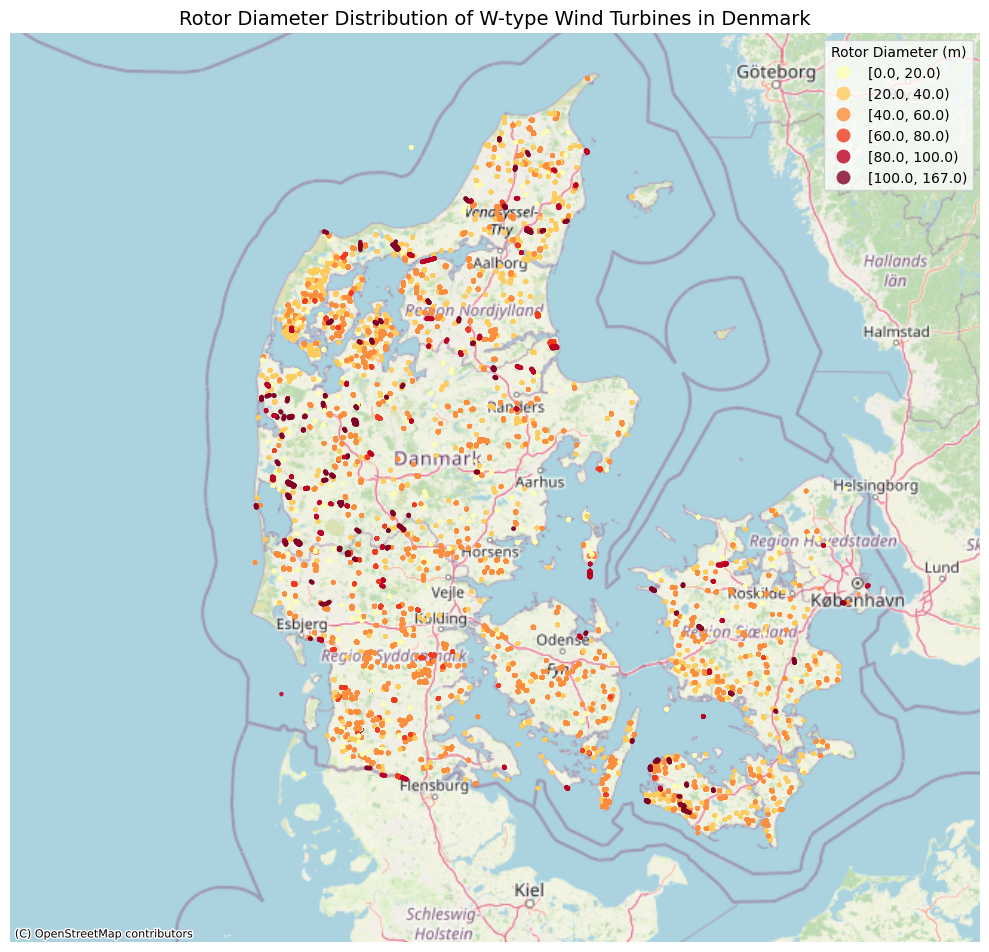

In [15]:
# 仅使用 W 型风机 + 有效转子直径 + 有坐标
available_w_rotor = gdf[
    (gdf['Turbine_type'] == 'W') &
    (gdf['status'] == 'Available') &
    (gdf['Rotor_diameter'].notnull()) &
    (gdf.geometry.notnull())
].copy()

# 坐标转换
available_w_rotor = available_w_rotor.to_crs(epsg=3857)

# 分箱（可按需调整）
bins = [0, 20, 40, 60, 80, 100, available_w_rotor['Rotor_diameter'].max()]
available_w_rotor['rotor_bin'] = pd.cut(
    available_w_rotor['Rotor_diameter'],
    bins=bins,
    right=False,
    include_lowest=True
)

# 自定义颜色映射（也可用 cmap='OrRd'）
colors = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026', '#800026']
cmap = ListedColormap(colors)

# 绘图
fig, ax = plt.subplots(figsize=(10, 12))

available_w_rotor.plot(
    ax=ax,
    column='rotor_bin',
    cmap=cmap,
    markersize=5,
    legend=True,
    alpha=0.8,
    legend_kwds={'title': 'Rotor Diameter (m)'}
)

ax.set_xlim(700000, 1500000)
ax.set_ylim(7200000, 7950000)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Rotor Diameter Distribution of W-type Wind Turbines in Denmark", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()